In [40]:
import pickle
import pandas as pd
import numpy as np

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

import matplotlib.pyplot as plt

from loaders import DataLoader
from strategies.arima import StrategyARIMA, StrategyARIMAGARCH
from backtester import BackTester

In [2]:
df = DataLoader.load('ibm', sampling='3H', year_start=2000)

# Intro

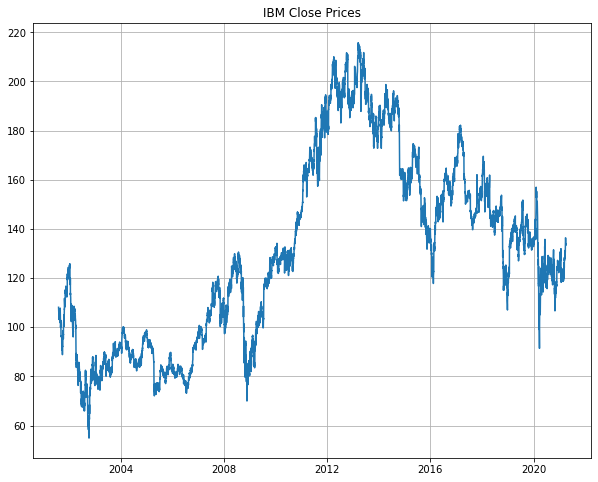

In [5]:
plt.figure(figsize=(10, 8))
plt.plot(df['Date'], df['Close'])
plt.title('IBM Close Prices')
plt.grid()
plt.show()

Quite a few linear models assume the stationarity in time series as they account for oscillations but not for trends. Usually raw financial time series are non-stationary. Let's test that using Dickey-Fuller test for stationarity.

In [10]:
temp_df = []
for year in df['Date'].dt.year.unique()[::3]:
    res = adfuller(df[df['Date'].dt.year == year]['Close'].values)
    temp_df.append({'year': year, 'p-value': round(res[1], 4)})
pd.DataFrame(temp_df)

,year,p-value
0,2001,0.8979
1,2004,0.7683
2,2007,0.5339
3,2010,0.8484
4,2013,0.5185
5,2016,0.6422
6,2019,0.0037


As we can see for each year p-value is above the significance level, therefore our time series are non-statinory. One of the most common ways is to take logarithmic returns of our time series which will convert the original price series from a non-stationary series to a potentially stationary one.

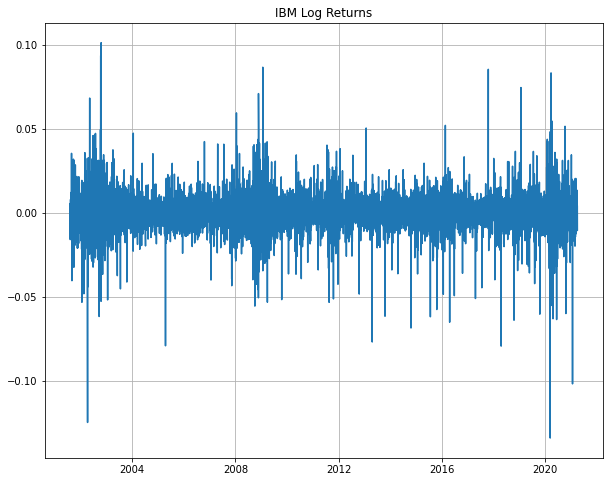

In [11]:
plt.figure(figsize=(10, 8))
plt.plot(df['Date'], df['ln_Close'])
plt.title('IBM Log Returns')
plt.grid()
plt.show()

To make sure let's rerun Dickey-Fuller test to see that p-values are less than the significance level now.

In [12]:
temp_df = []
for year in df['Date'].dt.year.unique()[::3]:
    res = adfuller(df[df['Date'].dt.year == year]['ln_Close'].values)
    temp_df.append({'year': year, 'p-value': round(res[1], 4)})
pd.DataFrame(temp_df)

,year,p-value
0,2001,0.0
1,2004,0.0
2,2007,0.0
3,2010,0.0
4,2013,0.0
5,2016,0.0
6,2019,0.0


Since we are going to use ARIMA as our baseline model we'll need to estimate parameters `p` and `q` which are auto-regressiona and moving average parameters respectively. We don't need to estimate integration parameter `d` as we've already taken care of it by taking log returns.

To get an idea of range of values that `p` and `q` can take let's plot the following correlograms which are simply the plots of the autocorrelation function for sequential values of lag. The main usage of correlograms is to detect any autocorrelation subsequent to the removal of any deterministic trends or seasonality effects.

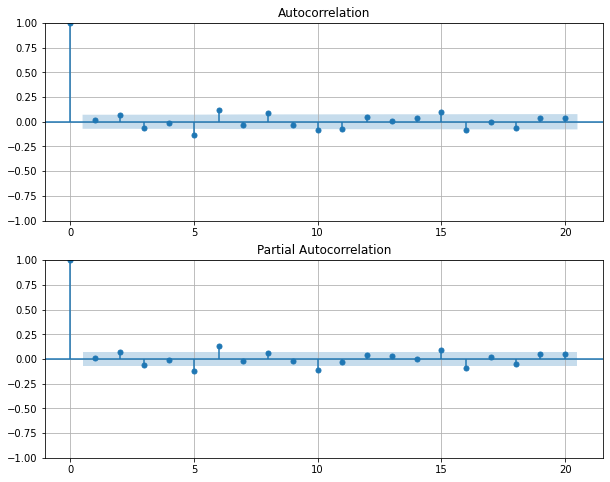

In [17]:
plt.figure(figsize=(10, 8))
ax = plt.subplot(211)
plot_acf(df[df['Date'].dt.year == 2020]['ln_Close'], lags=20, ax=ax)
plt.grid()
ax = plt.subplot(212)
plot_pacf(df[df['Date'].dt.year == 2020]['ln_Close'], lags=20, ax=ax, method='ywm')
plt.grid()
plt.show()

# ARCH/GARCH

### 1/ Length of window

In [56]:
def plot_pnl_helper(cache_path, flag=False):
    with open(cache_path, 'rb') as f:
        data = pickle.load(f)
    data['Pred'] = np.sign(data['Pred'])
    data = data.iloc[:int(0.8 * data.shape[0]), :]
    if flag:
        plt.plot(data['Date'], data['Close'].diff().cumsum(), label='Buy&Hold', linestyle='--', alpha=.6)
    plt.plot(data['Date'], data['Close'].diff().mul(data['Pred']).cumsum(), label=cache_path)

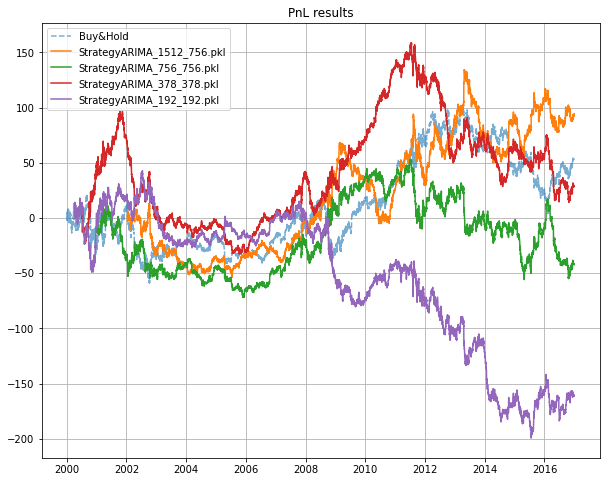

In [57]:
plt.figure(figsize=(10, 8))

plot_pnl_helper('StrategyARIMA_1512_756.pkl', True)
plot_pnl_helper('StrategyARIMA_756_756.pkl')
plot_pnl_helper('StrategyARIMA_378_378.pkl')
plot_pnl_helper('StrategyARIMA_192_192.pkl')

plt.grid()
plt.legend()
plt.title('PnL results')
plt.show()

### 2/ Refit frequency

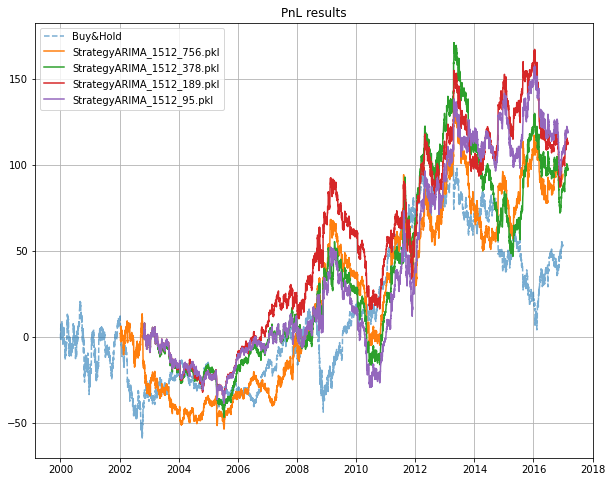

In [58]:
plt.figure(figsize=(10, 8))

plot_pnl_helper('StrategyARIMA_1512_756.pkl', True)
plot_pnl_helper('StrategyARIMA_1512_378.pkl')
plot_pnl_helper('StrategyARIMA_1512_189.pkl')
plot_pnl_helper('StrategyARIMA_1512_95.pkl')

plt.grid()
plt.legend()
plt.title('PnL results')
plt.show()

In [54]:
# strategy = StrategyARIMA()

# backtester = BackTester(data=df,
#                             strategy=strategy,
#                             window=3*252*2,
#                             refit_window=95)
# backtester.run()